In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [8]:
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [9]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [10]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


Text(0, 0.5, 'v')

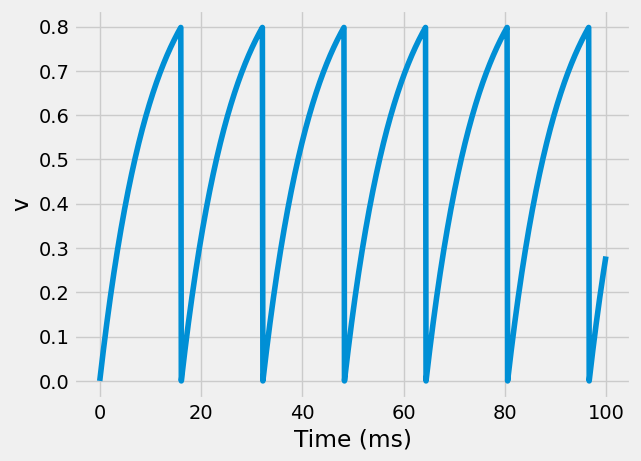

In [11]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

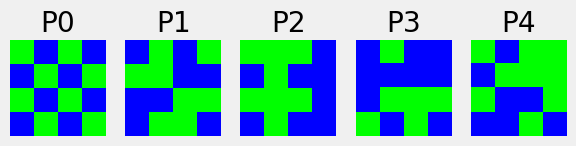

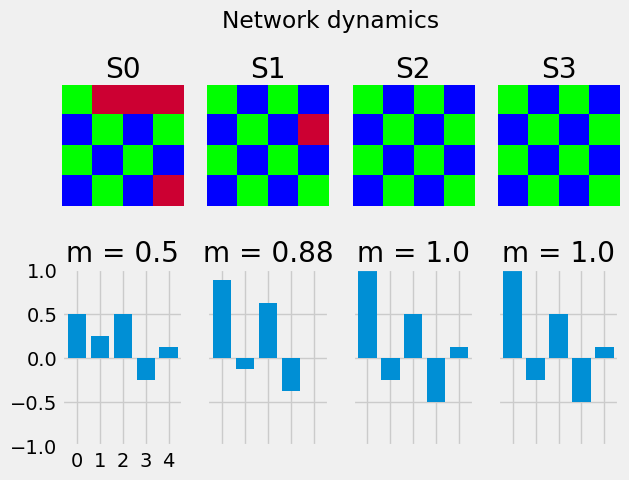

In [6]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

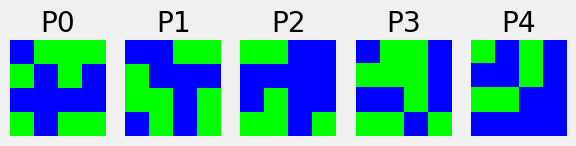

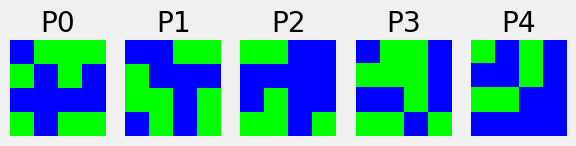

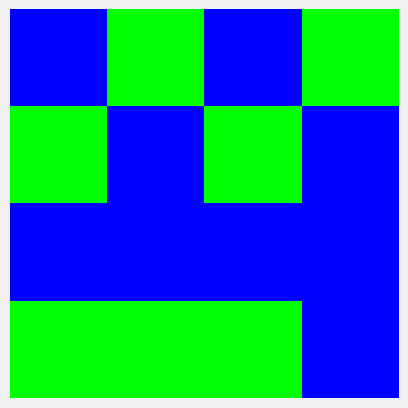

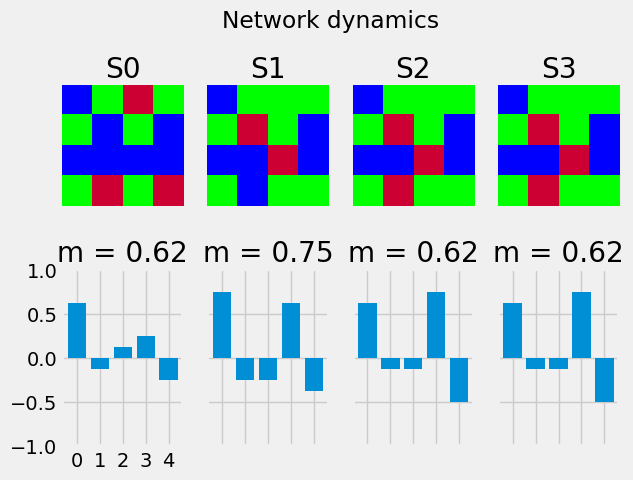

In [19]:
def get_patterns(pattern_size, num_patterns):
    factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
    pattern_list = factory.create_random_pattern_list(nr_patterns=num_patterns, on_probability=0.5)
    return pattern_list

def perturb_pattern(pattern, num_flips):
    noisy_pattern = pattern_tools.flip_n(pattern, nr_of_flips=num_flips)
    return noisy_pattern

def calculate_weights(pattern_list, pattern_size):
    hopfield_net = network.HopfieldNetwork(nr_neurons=pattern_size**2)
    hopfield_net.store_patterns(pattern_list)
    return hopfield_net.weights

def network_evolution(state, weights, num_steps=1):
    hopfield_net = network.HopfieldNetwork(nr_neurons=len(state))
    hopfield_net.weights = weights
    hopfield_net.set_state_from_pattern(state)
    states = hopfield_net.run_with_monitoring(nr_steps=num_steps)
    return states[-1]

# Create patterns
plist = get_patterns(pattern_size, 5)
plot_tools.plot_pattern_list(plist)

# Calculate weights
wghts = calculate_weights(plist, pattern_size)

# Perturb the first pattern
S = perturb_pattern(plist[0], 3)

# Run network evolution
state_list = [S]
for i in range(3):
    next_state = network_evolution(state_list[-1], wghts)
    state_list.append(next_state.reshape(pattern_size, pattern_size))

# Plot results
plot_tools.plot_pattern_list(plist)
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

Ans1. Below is an implemetation of Hopfield network which includes the basic functions of a network that is, storing patterns, updating the network state, and retrieving patterns from noisy cues.

letters are patterns of size: (10, 10). Create a network of corresponding size


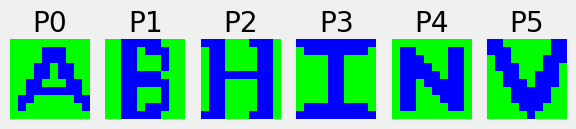

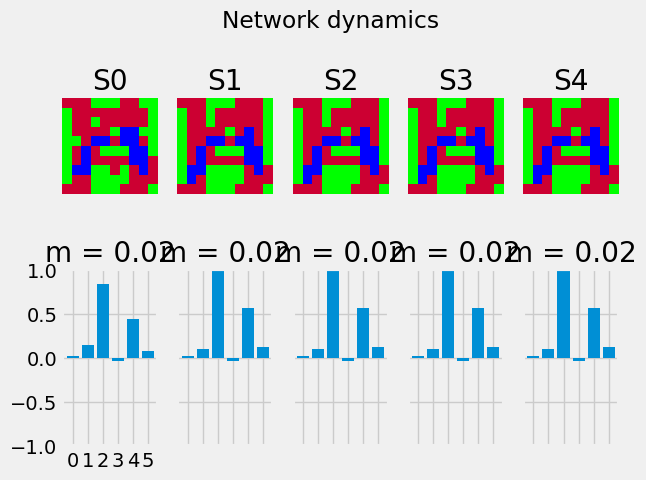

In [23]:
import matplotlib.pyplot as plt
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
import numpy

# the letters we want to store in the hopfield network
letter_list = ['A', 'B', 'H', 'I', 'N', 'V']

abc_dictionary =pattern_tools.load_alphabet()
# access the first element and get it's size (they are all of same size)
pattern_shape = abc_dictionary['H'].shape
print("letters are patterns of size: {}. Create a network of corresponding size".format(pattern_shape))
# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_shape[0]*pattern_shape[1])

# create a list using Pythons List Comprehension syntax:
pattern_list = [abc_dictionary[key] for key in letter_list ]
plot_tools.plot_pattern_list(pattern_list)

# store the patterns
hopfield_net.store_patterns(pattern_list)

# # create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.get_noisy_copy(abc_dictionary['H'], noise_level=0.2)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=4)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = pattern_tools.reshape_patterns(states, pattern_list[0].shape)

# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(
    states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

Ans 2 Now, let's analyze how the model's performance changes under different conditions:

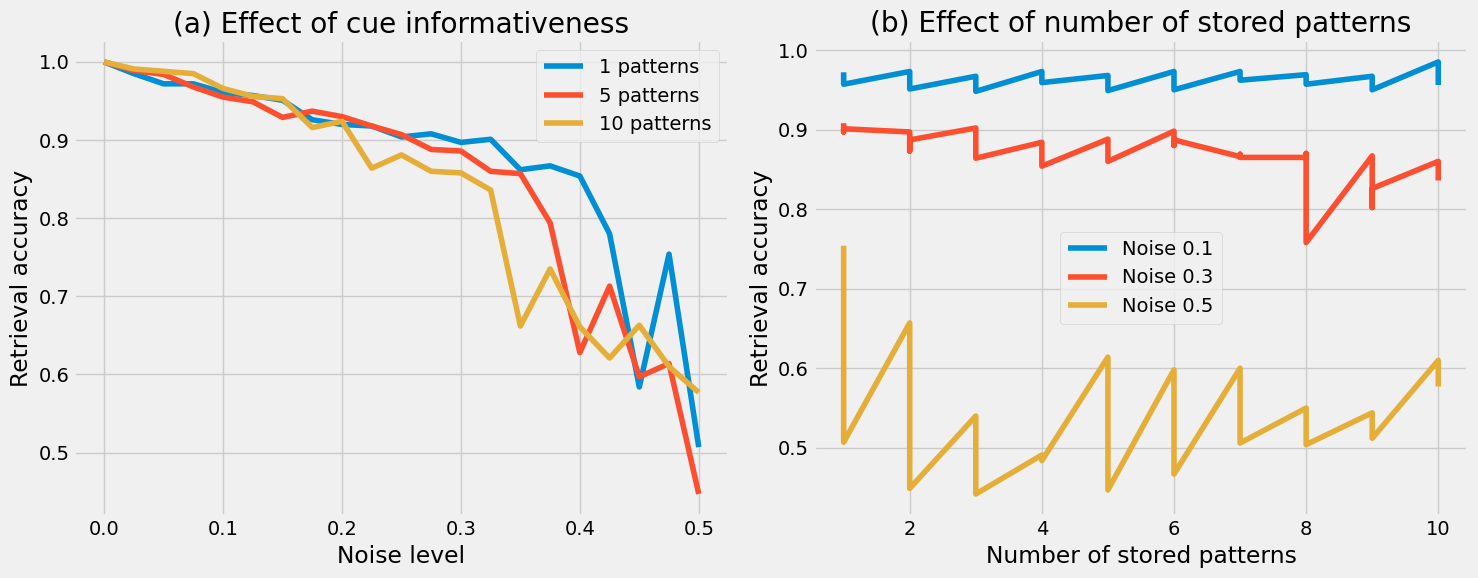

Theoretical capacity: 5.43 patterns


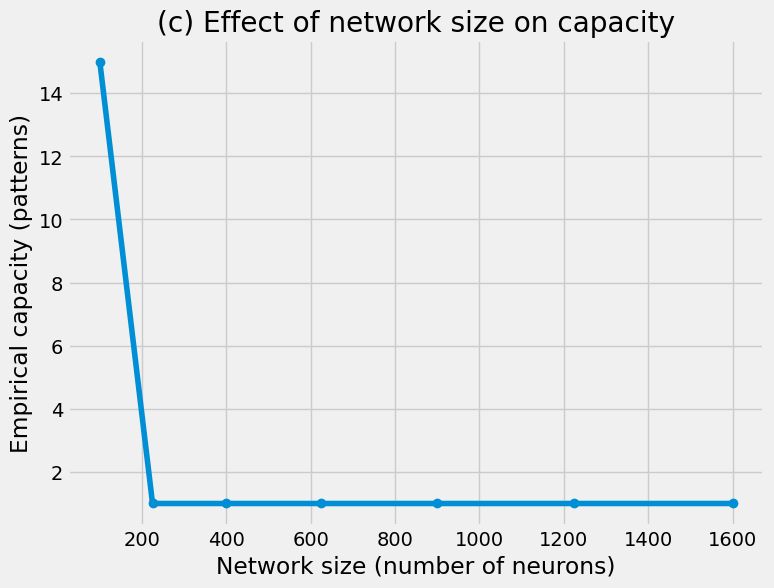

In [24]:
import numpy as np
import matplotlib.pyplot as plt

class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))
        self.state = None

    def store_patterns(self, patterns):
        for pattern in patterns:
            pattern = pattern.flatten()
            self.weights += np.outer(pattern, pattern)
        np.fill_diagonal(self.weights, 0)
        self.weights /= self.num_neurons

    def update(self, num_steps):
        for _ in range(num_steps):
            neuron = np.random.randint(0, self.num_neurons)
            activation = np.dot(self.weights[neuron], self.state)
            self.state[neuron] = 1 if activation >= 0 else -1

    def run(self, initial_state, num_steps):
        self.state = initial_state.flatten()
        self.update(num_steps)
        return self.state.reshape(initial_state.shape)

def generate_random_pattern(size):
    return np.random.choice([-1, 1], size=size)

def add_noise(pattern, noise_level):
    mask = np.random.random(pattern.shape) < noise_level
    noisy_pattern = pattern.copy()
    noisy_pattern[mask] *= -1
    return noisy_pattern

def pattern_similarity(pattern1, pattern2):
    return np.mean(pattern1 == pattern2)

def experiment(pattern_size, num_patterns, noise_levels, num_trials=10):
    results = []
    
    for num_stored in range(1, num_patterns + 1):
        for noise in noise_levels:
            similarities = []
            for _ in range(num_trials):
                # Generate patterns
                patterns = [generate_random_pattern(pattern_size) for _ in range(num_stored)]
                
                # Create and train network
                network = HopfieldNetwork(pattern_size[0] * pattern_size[1])
                network.store_patterns(patterns)
                
                # Test retrieval
                target_pattern = patterns[0]
                noisy_pattern = add_noise(target_pattern, noise)
                retrieved_pattern = network.run(noisy_pattern, num_steps=100)
                
                similarity = pattern_similarity(target_pattern, retrieved_pattern)
                similarities.append(similarity)
            
            results.append((num_stored, noise, np.mean(similarities)))
    
    return results

# Run experiments
pattern_size = (10, 10)
num_patterns = 10
noise_levels = np.linspace(0, 0.5, 21)  # Increase the number of noise levels for smoother curves

results = experiment(pattern_size, num_patterns, noise_levels)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot (a) informativeness of the cue
for num_stored in [1, 5, 10]:
    data = [(noise, sim) for stored, noise, sim in results if stored == num_stored]
    noise, sim = zip(*data)
    ax1.plot(noise, sim, label=f'{num_stored} patterns')

ax1.set_xlabel('Noise level')
ax1.set_ylabel('Retrieval accuracy')
ax1.set_title('(a) Effect of cue informativeness')
ax1.legend()

# Plot (b) number of stored patterns
for target_noise in [0.1, 0.3, 0.5]:
    data = [(stored, sim) for stored, noise, sim in results if np.isclose(noise, target_noise, atol=0.025)]
    if data:
        stored, sim = zip(*data)
        ax2.plot(stored, sim, label=f'Noise {target_noise}')

ax2.set_xlabel('Number of stored patterns')
ax2.set_ylabel('Retrieval accuracy')
ax2.set_title('(b) Effect of number of stored patterns')
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate theoretical capacity
N = pattern_size[0] * pattern_size[1]
theoretical_capacity = N / (4 * np.log(N))
print(f"Theoretical capacity: {theoretical_capacity:.2f} patterns")

# Plot (c) network size effect
network_sizes = [100, 225, 400, 625, 900, 1225, 1600]
capacities = []

for size in network_sizes:
    pattern_size = (int(np.sqrt(size)), int(np.sqrt(size)))
    results = experiment(pattern_size, num_patterns=20, noise_levels=[0.1])
    capacity = next((stored for stored, _, sim in results if sim < 0.95), len(results))
    capacities.append(capacity)

plt.figure(figsize=(8, 6))
plt.plot(network_sizes, capacities, 'o-')
plt.xlabel('Network size (number of neurons)')
plt.ylabel('Empirical capacity (patterns)')
plt.title('(c) Effect of network size on capacity')
plt.show()

Ans 3. here is the rquired function. I would like to mention that there was some issue in the librarie such that whenever i was fetching data from the URL then it was not able to and funnily enough eben when I used tensorflow to used the MNIST data which are pre-loaded in it then I was faced with the error that it was not able to fetch from the URL, the cause of which I have been unable to comprehend. So i downloaded the dataset locally and then wrote my code accordingly. I hope thats okay.

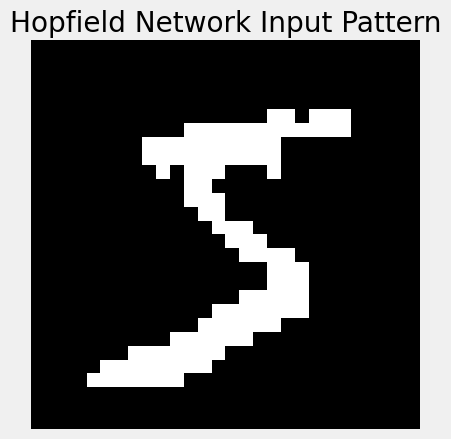

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def convert_mnist_to_hopfield_pattern(mnist_data):
    # Normalize the pixel values (MNIST digits are 28x28 images with pixel values ranging from 0 to 255)
    normalized_data = mnist_data / 255.0
    
    # Convert the normalized data into a binary pattern
    # Values greater than 0.5 become 1, others become -1
    binary_pattern = np.where(normalized_data > 0.5, 1, -1)
    
    # Reshape the binary pattern into a 1D array (784 elements)
    pattern = binary_pattern.reshape(-1)
    
    return pattern, binary_pattern

def load_mnist_from_npz(npz_file_path):
    # Load the MNIST dataset from the .npz file
    with np.load(npz_file_path) as data:
        train_images = data['x_train']
        train_labels = data['y_train']
        test_images = data['x_test']
        test_labels = data['y_test']

    # Convert the first image from the training set to a Hopfield pattern
    hopfield_pattern, binary_pattern = convert_mnist_to_hopfield_pattern(train_images[0])

    return hopfield_pattern, binary_pattern, train_images, train_labels, test_images, test_labels

def visualize_pattern(binary_pattern):
    # Reshape the binary pattern back to a 28x28 image for visualization
    image = binary_pattern.reshape(28, 28)
    
    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title('Hopfield Network Input Pattern')
    plt.axis('off')
    plt.show()

# Example usage
npz_file_path = '/Users/lykofos/Desktop/study/SEM-3/CS786/mnist.npz'  # Replace with the actual path to mnist.npz
pattern, binary_pattern, train_images, train_labels, test_images, test_labels = load_mnist_from_npz(npz_file_path)

# Visualize the pattern
visualize_pattern(binary_pattern)


Ans 4. Here is the MNIST classifier and rison between the original, corrupted and retrieved pattern. the same thing as above applies that I have used the dataset from my local source.

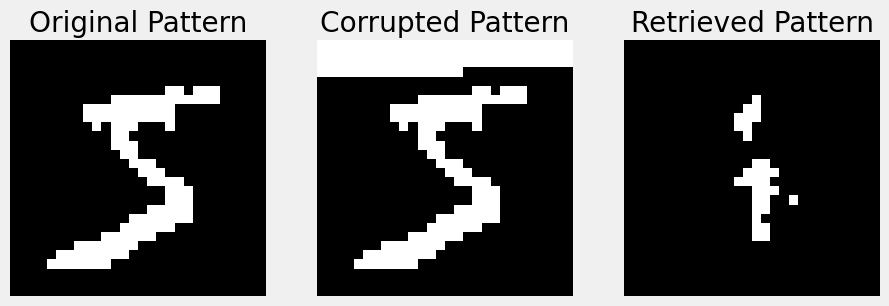

In [21]:
import numpy as np

class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))

    def train(self, patterns):
        # Train the network on each pattern
        for p in patterns:
            self.weights += np.outer(p, p)
        # Ensure no neuron has a self-connection
        np.fill_diagonal(self.weights, 0)

    def retrieve(self, pattern, steps=5):
        for _ in range(steps):
            pattern = np.sign(np.dot(self.weights, pattern))
        return pattern

    def energy(self, pattern):
        return -0.5 * np.dot(pattern, np.dot(self.weights, pattern))

def binarize_data(data):
    return np.where(data > 0.5, 1, -1)

#Load the MNIST Data
def load_mnist_from_npz(npz_file_path):
    with np.load(npz_file_path) as data:
        train_images = data['x_train']
        train_labels = data['y_train']
        test_images = data['x_test']
        test_labels = data['y_test']

    return train_images, train_labels, test_images, test_labels

# Train and Test the Hopfield Network
def train_and_test_hopfield(npz_file_path):
    # Load data
    train_images, train_labels, test_images, test_labels = load_mnist_from_npz(npz_file_path)
    
    # Binarize the first 10 images from each class
    patterns = [binarize_data(train_images[i].flatten() / 255.0) for i in range(10)]
    
    # Create and train the Hopfield network
    hopfield = HopfieldNetwork(num_neurons=784)
    hopfield.train(patterns)

    # Test the Hopfield network by corrupting the first pattern and trying to retrieve it
    corrupted_pattern = np.copy(patterns[0])
    corrupted_pattern[:100] = -corrupted_pattern[:100]  # Corrupt the first 100 pixels

    retrieved_pattern = hopfield.retrieve(corrupted_pattern)

    # Reshape for visualization
    retrieved_image = retrieved_pattern.reshape(28, 28)

    # Visualize original, corrupted, and retrieved images
    visualize_patterns(patterns[0].reshape(28, 28), corrupted_pattern.reshape(28, 28), retrieved_image)

def visualize_patterns(original, corrupted, retrieved):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original Pattern')
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Corrupted Pattern')
    plt.imshow(corrupted, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Retrieved Pattern')
    plt.imshow(retrieved, cmap='gray')
    plt.axis('off')

    plt.show()

# Example usage
npz_file_path = '//Users/lykofos/Desktop/study/SEM-3/CS786/mnist.npz'  # Replace with the actual path to mnist.npz
train_and_test_hopfield(npz_file_path)


this is a second part of ans4 where i calculate teh accuracy. 

In [2]:
import numpy as np
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

# Hopfield Network Implementation
class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))

    def train(self, patterns):
        for p in patterns:
            self.weights += np.outer(p, p)
        np.fill_diagonal(self.weights, 0)

    def retrieve(self, pattern, steps=10):
        for _ in range(steps):
            pattern = np.sign(np.dot(self.weights, pattern))
        return pattern

def binarize_data(data, threshold=0.5):
    return np.where(data > threshold, 1, -1)

def load_mnist_from_npz(npz_file_path):
    with np.load(npz_file_path) as data:
        train_images = data['x_train']
        train_labels = data['y_train']
        test_images = data['x_test']
        test_labels = data['y_test']

    return train_images, train_labels, test_images, test_labels

# Function to train and test Hopfield classifier
def train_and_test_hopfield_classifier(npz_file_path, num_samples_per_class=50, retrieval_steps=10):
    train_images, train_labels, test_images, test_labels = load_mnist_from_npz(npz_file_path)
    
    # Initialize Hopfield networks, one per digit class
    hopfields = {i: HopfieldNetwork(num_neurons=784) for i in range(10)}

    # Train the Hopfield networks with more samples from each class
    for i in range(10):
        class_images = train_images[train_labels == i][:num_samples_per_class]  # Use more samples per digit class
        patterns = [binarize_data(img.flatten() / 255.0) for img in class_images]
        hopfields[i].train(patterns)

    # Test the Hopfield networks
    predicted_labels = []
    true_labels = []

    for img, label in zip(test_images, test_labels):
        binarized_img = binarize_data(img.flatten() / 255.0)
        retrieved_patterns = {i: hopfields[i].retrieve(binarized_img, steps=retrieval_steps) for i in range(10)}
        
        # Find the class with the minimum energy (most likely class)
        energies = {i: -0.5 * np.dot(retrieved_patterns[i], np.dot(hopfields[i].weights, retrieved_patterns[i])) for i in range(10)}
        predicted_label = min(energies, key=energies.get)
        
        predicted_labels.append(predicted_label)
        true_labels.append(label)

    # Calculate F1-Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f"F1-Score: {f1}")
    
    # Classification report
    print(classification_report(true_labels, predicted_labels))

# Example usage
npz_file_path = '/Users/lykofos/Desktop/study/SEM-3/CS786/mnist.npz'  # Replace with the actual path to mnist.npz
train_and_test_hopfield_classifier(npz_file_path, num_samples_per_class=50, retrieval_steps=10)


F1-Score: 0.023138302649304
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Hopfield networks are great for recalling patterns from noisy data and are simple to implement. They work well when you need to retrieve specific memories or patterns, making them intuitive and robust in certain contexts. However, they struggle with large datasets and complex tasks like MNIST digit classification because their capacity is limited, and they don't scale well. As classifiers, they fall short compared to modern machine learning techniques like SVMs or deep learning models, which are far more effective for large-scale image recognition tasks. Overall, Hopfield networks have niche uses but aren't suitable for general classification tasks. Optimal performance requires managing the trade-offs between network size, number of stored patterns, and the quality of the initial cue.